In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy import stats
from scipy.signal import get_window
import glob
import time

#The FFT assumes that the signal is periodic and continuous within the window. 
#If the signal is not perfectly periodic, it can cause spectral leakage, which results in an offset or differences in the frequency spectrum.
def rffts(ys): #the imput are 2d arrays bc this function computes multiple ffts
    #window = get_window("hanning", ys.shape[1])
    #window = np.ones(ys.shape[1])
    #print(window.shape)
    #print(ys.shape)

    #ys_windowed = ys * window[np.newaxis, :]
    Ys = fft.rfft(ys, axis = 1) 
    
    return np.abs(Ys)

def filtering_func(freqs, fft, f1, f2):
    filtered_fft = fft.copy() #in this way it doesn't reference to fft
    std = np.std(fft[(freqs >= f1) & (freqs <= f2)])
    print(f"std: {std}")

    range_avg = np.mean(fft[(freqs >= f1) & (freqs <= f2)])
    print(f'range_avg: {range_avg}')
    peak = np.max(fft[(freqs >= f1) & (freqs <= f2)])

    peak_f = freqs[fft == peak]
    print(f"peak_f: {peak_f}")

    peak_height = peak - range_avg
    radius = peak_height/0.03 # height = +- 2% of width  
    print(f'peak_f - radius: {peak_f - radius}')
    print(f'peak_f + radius: {peak_f + radius}')

    peak_values = fft[(freqs >= peak_f - radius) & (freqs <= peak_f + radius)]
    print(f'peak_values: {peak_values}')

    new_values = np.random.normal(range_avg, std, peak_values.size) 
    print(f'new_values: {new_values}')
    filtered_fft[np.isin(fft, peak_values)] = new_values
    return filtered_fft

In [16]:
hour = '15.42'
day = '08082024'

In [17]:
file_pattern_wfs = f"../../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list_wfs = glob.glob(file_pattern_wfs)

amplitudes_list = []


if not file_list_wfs:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list_wfs):
        df = pd.read_csv(file)
        if i == 0:
            print(df.iloc[:, 0])
            print(df.iloc[:, 1])
            times = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
        amplitudes = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
        amplitudes_list.append(amplitudes)
        
all_amplitudes = np.stack(amplitudes_list, axis = 0)
N = len(times)
print(f"len(times): {N}")

0               (us)
1         0.00000000
2         0.00080000
3         0.00160000
4         0.00240000
            ...     
62500    49.99920067
62501    50.00000067
62502    50.00080067
62503    50.00160067
62504    50.00240067
Name: Time, Length: 62505, dtype: object
0               (mV)
1        -1.96850400
2        -1.57480300
3        -1.18110200
4        -0.78740150
            ...     
62500     0.00000000
62501     0.39370070
62502    -0.39370070
62503    -1.18110200
62504    -1.18110200
Name: Channel D, Length: 62505, dtype: object
len(times): 62504


In [18]:
print(all_amplitudes)

[[-1.968504  -1.574803  -1.181102  ... -0.3937007 -1.181102  -1.181102 ]
 [ 1.574803   0.7874015  0.        ... -0.3937007 -2.755905  -4.724409 ]
 [-0.3937007 -0.3937007  0.3937007 ... -0.7874015 -2.362205  -3.149606 ]
 ...
 [-3.149606  -2.755905  -1.181102  ...  3.149606   3.149606   2.755905 ]
 [ 1.574803   1.574803   1.574803  ...  3.149606   3.149606   1.574803 ]
 [ 1.181102   1.574803   2.755905  ...  2.755905   1.968504   2.362205 ]]


## FFT

In [19]:
Ys = rffts(all_amplitudes)
avg_fft = np.mean(Ys, axis = 0)
n = np.max(avg_fft)

In [20]:
avg_fft_au = avg_fft / n

span: 50.00240067
f_s = 1250.0199822905822


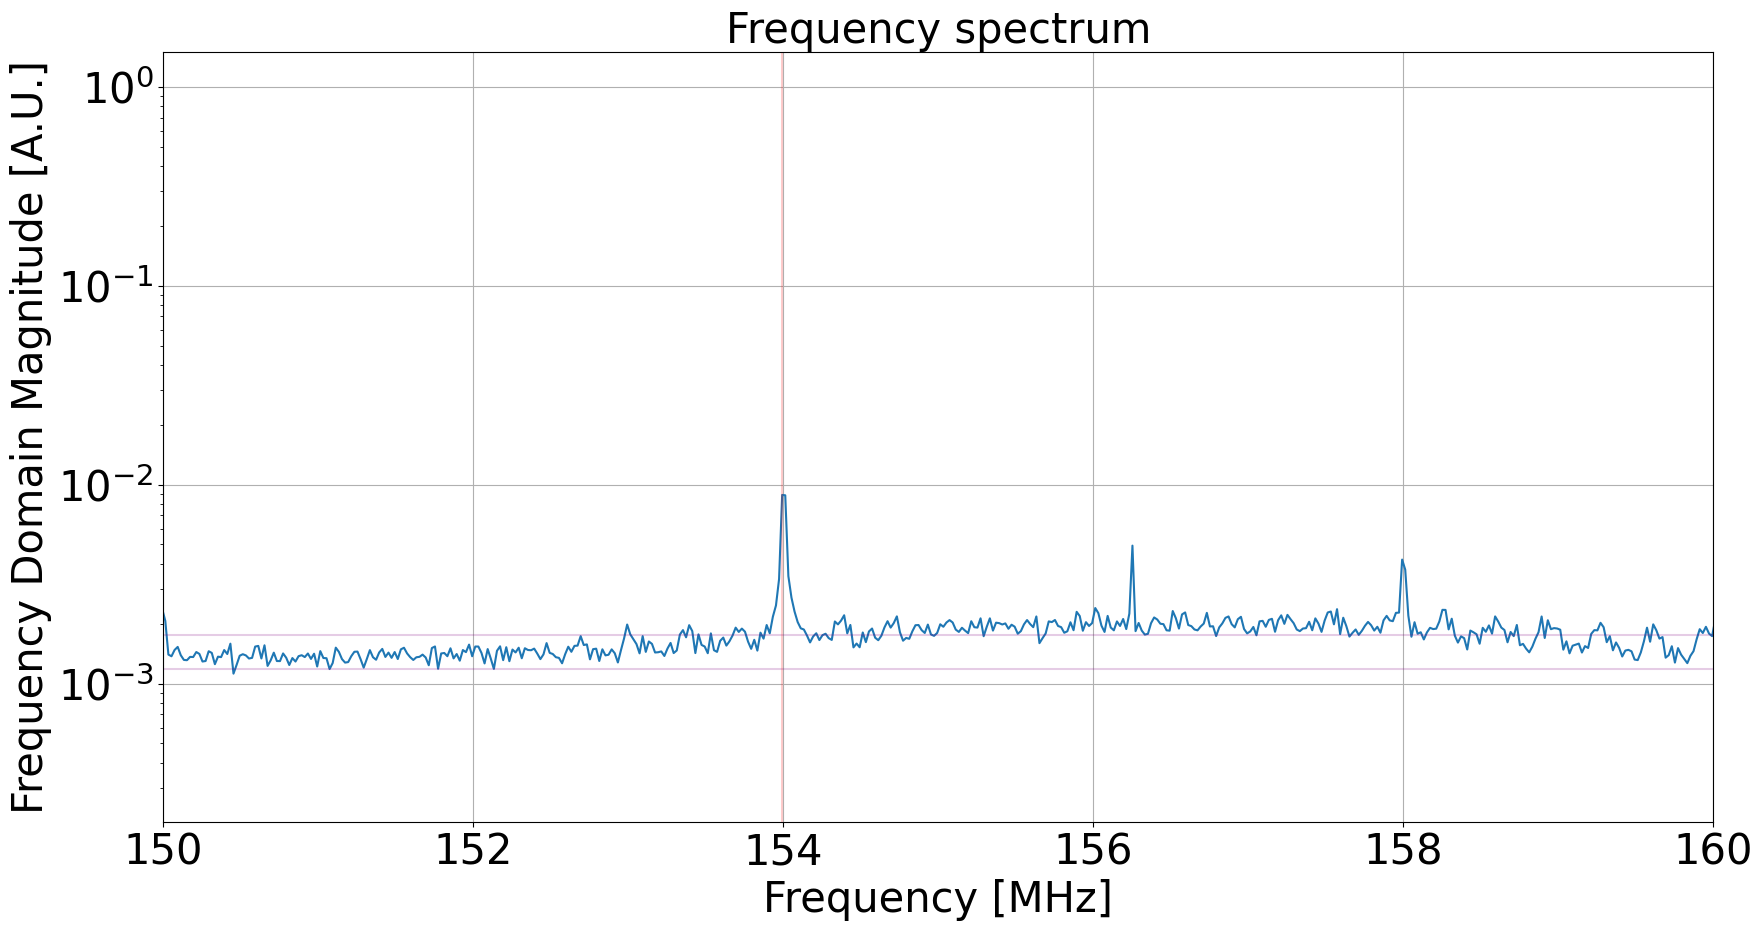

In [217]:
span = times[-1]
print(f"span: {span}") 
f_s = len(times) / span
print(f"f_s = {f_s}")
freqs = fft.rfftfreq(all_amplitudes.shape[1], 1/f_s) #window lenght, sample spacing

f1 = 150
f2 = 160

plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, avg_fft_au, yerr = stds_fft, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs, avg_fft_au)
plt.axhline(0.0017602908351023077 - 0.0005813111236623079, color = 'purple', alpha = 0.2, label = 'range mean')
plt.axhline(0.0017602908351023077, color = 'purple', alpha = 0.2, label = 'range mean')

plt.axvline(153.99260629, color = 'red', alpha = 0.2)
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.semilogy()
plt.grid(True)
plt.xlim(f1, f2)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

## Filtering

In [218]:
print(avg_fft_au[(freqs >= 153) & (freqs <= 155)])
filtered_fft = filtering_func(freqs, avg_fft_au, f1, f2)


[0.00176705 0.00166888 0.00157872 0.00141807 0.00173104 0.0014423
 0.0016269  0.00158196 0.0014323  0.00143635 0.00145017 0.00137572
 0.00149843 0.00159978 0.00142284 0.00146616 0.00176242 0.00185574
 0.00170747 0.00196505 0.00183461 0.0014228  0.00176643 0.00156319
 0.001535   0.00142032 0.00178636 0.00147073 0.0014424  0.00163927
 0.00170172 0.00155122 0.00163109 0.0017435  0.00190959 0.00181662
 0.00188848 0.00182256 0.00162357 0.00149415 0.00165869 0.00146361
 0.00180172 0.00168144 0.00196815 0.00178851 0.00216607 0.00246802
 0.0033491  0.00887431 0.00883441 0.00346868 0.00270213 0.00229903
 0.00203784 0.00189416 0.00186892 0.00174343 0.00160921 0.00172452
 0.00178875 0.00165366 0.00174989 0.00177924 0.00169174 0.00165668
 0.00205101 0.00198309 0.00207121 0.00220382 0.00178777 0.00196999
 0.00151945 0.00158849 0.00152162 0.00180552 0.00161454 0.00182723
 0.00188999 0.00169947 0.00165104 0.00173852 0.00191393 0.00205752
 0.00191058 0.00201298 0.00217547 0.00180942 0.00164187 0.00169

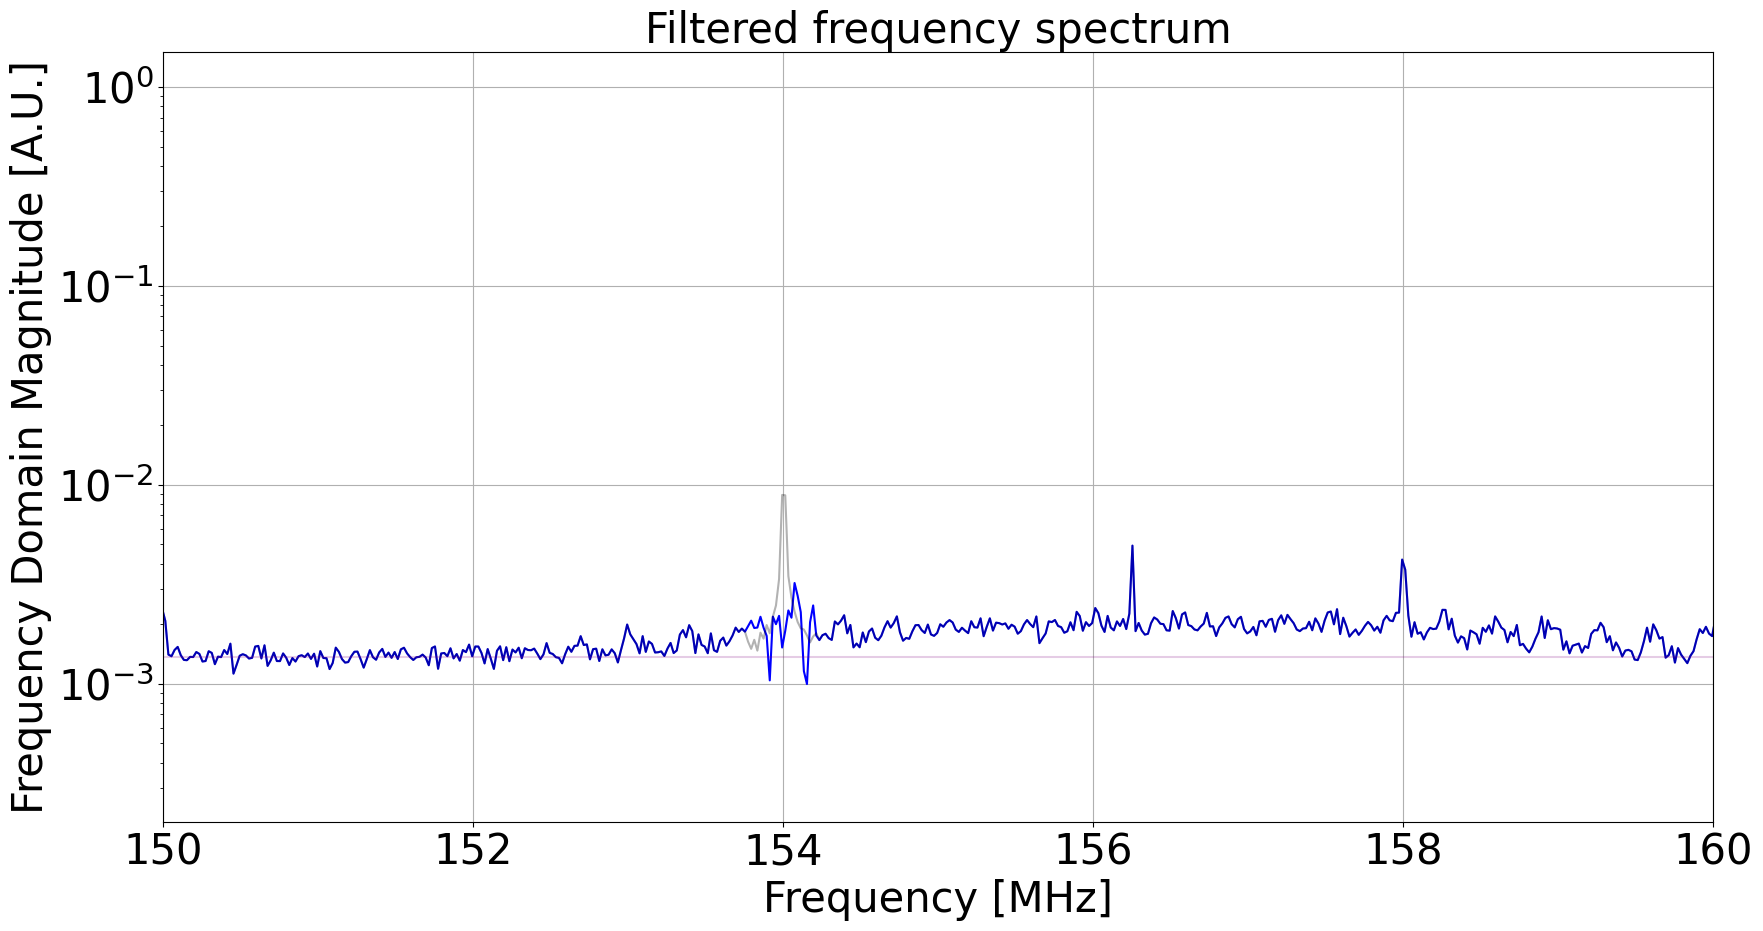

In [219]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, avg_fft_au, yerr = stds_fft, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs, filtered_fft, color = 'blue')
plt.plot(freqs, avg_fft_au, alpha = 0.3, color = 'k')
plt.axhline(0.0013569090855416659, color = 'purple', alpha = 0.2)

#plt.axvline(465.97762683, color = 'red')
plt.title('Filtered frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.semilogy()
plt.grid(True)
plt.xlim(f1, f2)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

## IFFT

In [220]:
times_ifft = np.arange(N) / f_s 
amplitudes_ifft = fft.irfft(filtered_fft)

## Compare to average waveform

In [221]:
original_wf = fft.irfft(avg_fft_au)

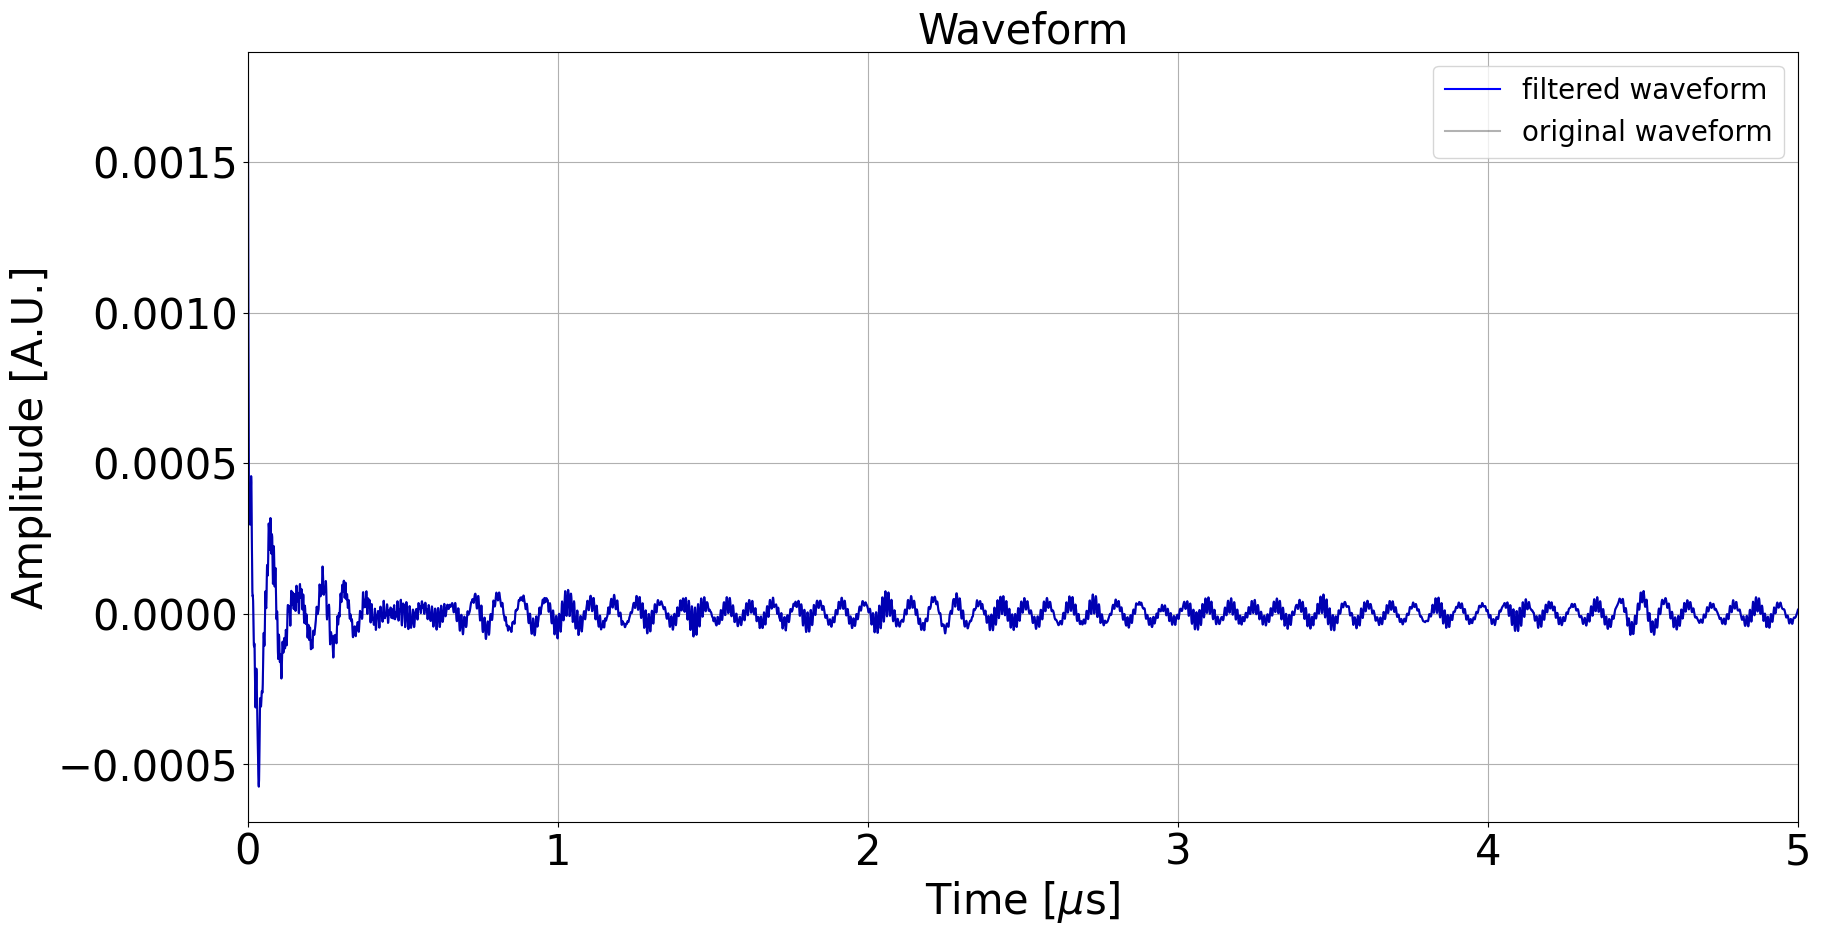

In [222]:
plt.figure(figsize = (20, 10))
plt.plot(times_ifft, amplitudes_ifft, label = 'filtered waveform', color = 'blue')
plt.plot(times_ifft, original_wf, label = 'original waveform', color = 'k', alpha = 0.3)
plt.title('Waveform', fontsize = 30)
plt.xlabel(r'Time [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(0, 5)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

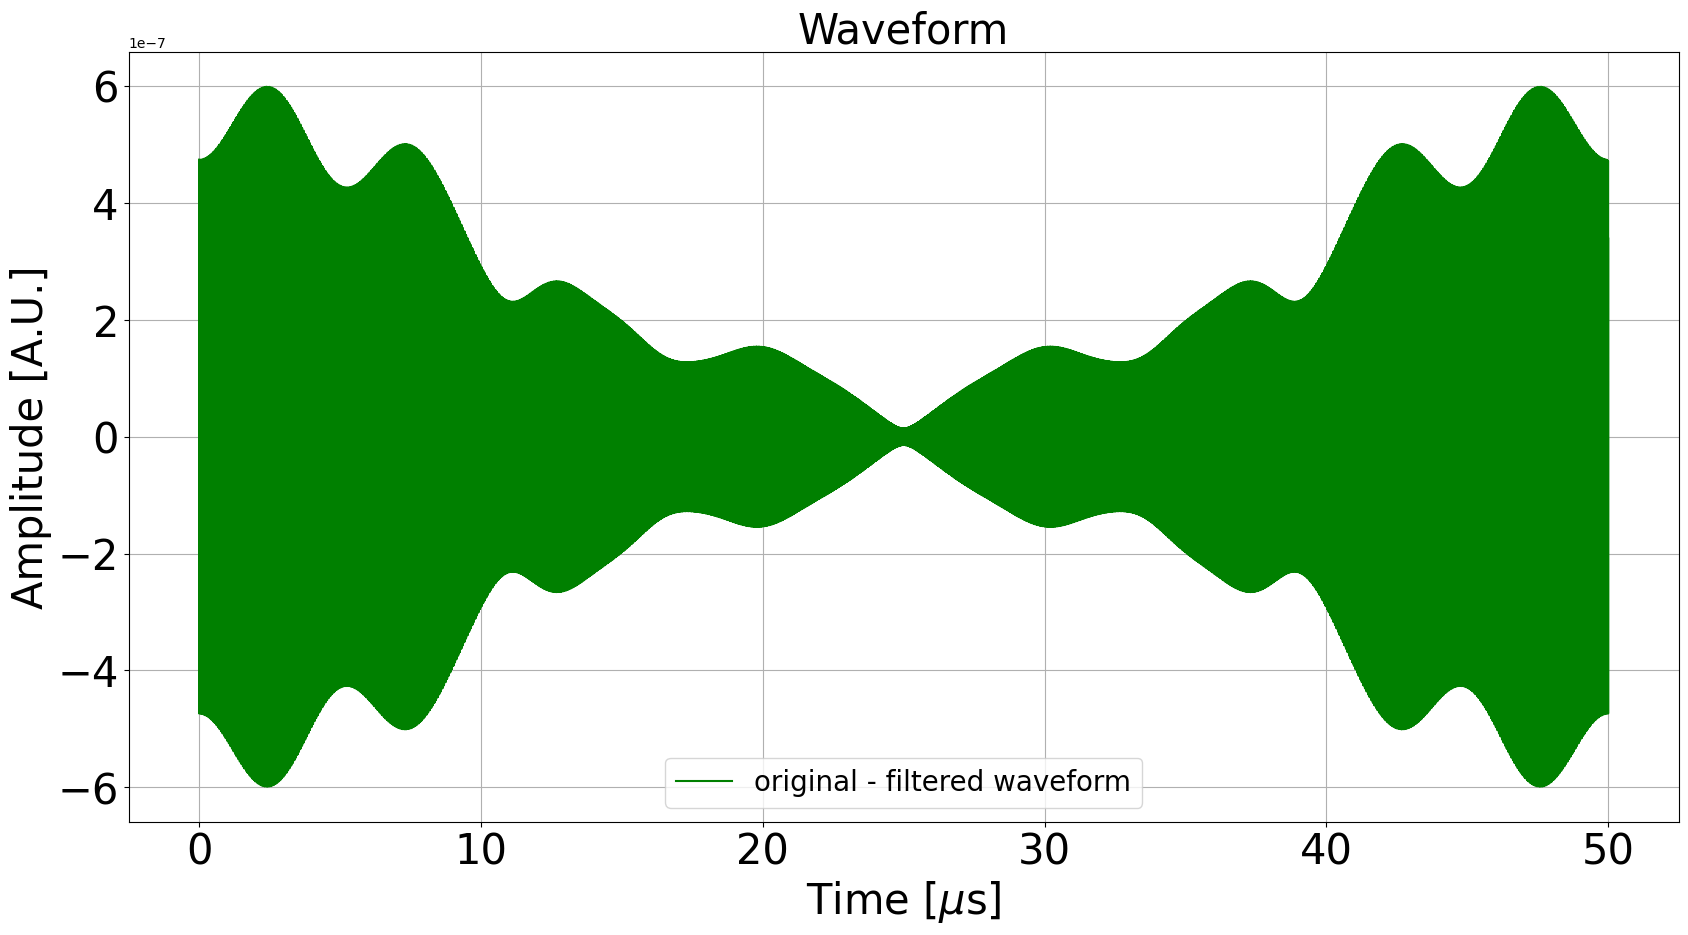

In [230]:
plt.figure(figsize = (20, 10))
plt.plot(times_ifft, original_wf - amplitudes_ifft, label = 'original - filtered waveform', color = 'green')
plt.title('Waveform', fontsize = 30)
plt.xlabel(r'Time [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
#plt.xlim(0, 0.2)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()